# Application of Variational Autoencoder: EMNIST

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

import sys, os
sys.path.append(os.path.abspath(".."))  # so it finds the 'vae' module

from autoencoder.vae import VAE
from autoencoder.utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Non-Convolutional Variational Autoencoder

In [4]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_flat = torchvision.datasets.EMNIST('./data/', train=True, download=True, split='balanced',
                                      transform=torchvision.transforms.Compose([
                                          torchvision.transforms.Resize((img_size,img_size)),
                                          torchvision.transforms.ToTensor(), # creating tensors
                                          torchvision.transforms.Lambda(lambda x: x.transpose(1, 2)),
                                          torchvision.transforms.Lambda((lambda x: torch.flatten(x).to(device))), # Tensor([784])
                            ]))
label_mapping = ds_flat.class_to_idx

### Data Exploration

x.shape: torch.Size([784])
type(t): <class 'int'>


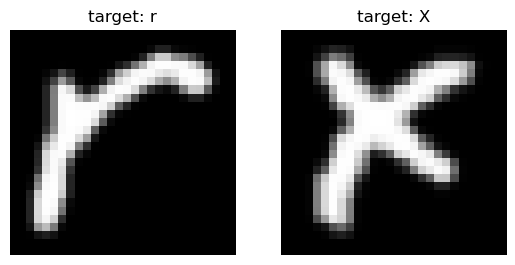

In [9]:
i, j = random.randint(0, 1024), random.randint(0, 1024)
x1,t1 = ds_flat.__getitem__(i)
x2, t2 = ds_flat.__getitem__(j)

print(f"x.shape: {x1.shape}")
print(f"type(t): {type(t1)}")

plt.subplot(1, 2, 1)

draw(x1, f"target: {convert_i2c(t1)}")

plt.subplot(1, 2, 2)
draw(x2, f"target: {convert_i2c(t2)}")
plt.show()

In [13]:
batch_size = 64
ds = torch.utils.data.Subset(ds_flat, range(5000))
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

### Training the Variational Autoencoder

100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Logged training session to vae_mlp_train_log.csv


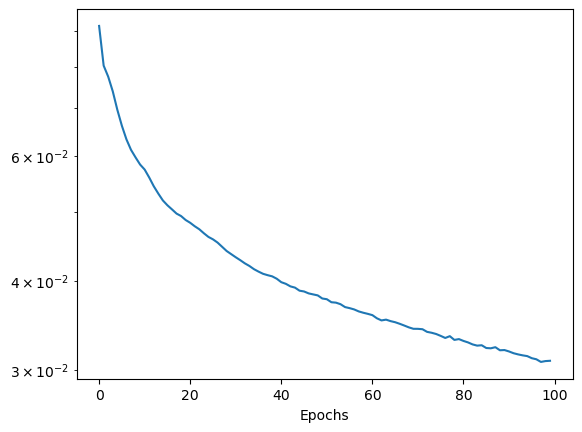

In [19]:
# Training the autoencoder
epochs = 100
lr = 0.001
h_dim = 100
latent_dim = 16
beta = 0.01

vae = VAE(in_dim=img_size**2, h_dim=h_dim,latent_dim=latent_dim, beta=beta,
          decoder=nn.Sequential(
              nn.Linear(latent_dim, 512), nn.ReLU(),
              nn.Linear(512, 1024), nn.ReLU(),
              nn.Linear(1024, img_size**2), nn.Sigmoid()
              ), 
          loss_fcn=nn.MSELoss())
vae.learn(dl, epochs=epochs, lr=lr)

log_training_session({
    'epochs': epochs,
    'lr': lr,
    'h_dim': h_dim,
    'latent_dim': latent_dim,
    'beta': beta,
    'final_loss': vae.losses[-1]  # final loss after training
})

In [ ]:
# Save model
model_name = f"model/vae_mlp_(epochs={epochs})_(lr={lr})_(beta={beta})_(latent_dim={latent_dim}).pth"
torch.save(vae, model_name)

In [ ]:
# Load trained model
# model = torch.load("model/vae_mlp_20e_001lr.pth", weights_only=False)

### Reconstruction of Input using VAE

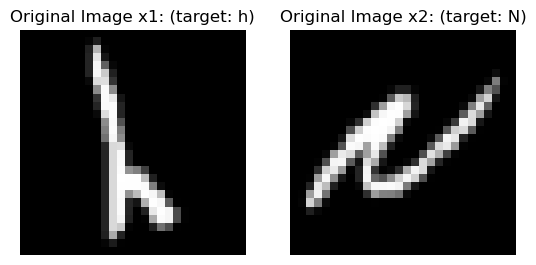

In [20]:
idx1 = random.randint(0, 3204)
x1, t1 = ds_flat.__getitem__(idx1)

idx2 = random.randint(0, 3204)
x2, t2 = ds_flat.__getitem__(idx2)

plt.subplot(1,2, 1)
draw(x1, f"Original Image x1: (target: {convert_i2c(t1)})")
plt.subplot(1,2, 2)

draw(x2, f"Original Image x2: (target: {convert_i2c(t2)})")

In [21]:
# Encode images into latent distributions
mu1, sigma1 = vae.encoder(x1.unsqueeze(0))
mu2, sigma2 = vae.encoder(x2.unsqueeze(0))

### Image Reconstruction

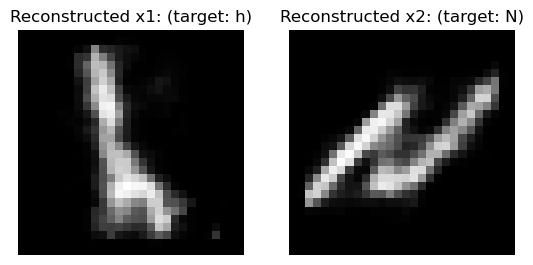

In [22]:
y1 = vae.decoder(mu1)
y1 = y1.squeeze(0)

plt.subplot(1,2,1)
draw(y1, f"Reconstructed x1: (target: {convert_i2c(t1)})")

y2 = vae.decoder(mu2)
y2 = y2.squeeze(0)
plt.subplot(1,2,2)
draw(y2, f"Reconstructed x2: (target: {convert_i2c(t2)})")

### Generative Sampling from Trained VAE

In [37]:
# z = torch.randn(vae.latent_dim)
z = torch.randn(vae.latent_dim)
z

tensor([ 0.8853, -1.9052, -0.2617, -0.4669,  0.1282,  0.4430,  0.0287, -1.3899,
         0.7701, -0.3565, -1.9044, -0.7178, -1.1480, -1.3117, -0.2182,  1.4058])

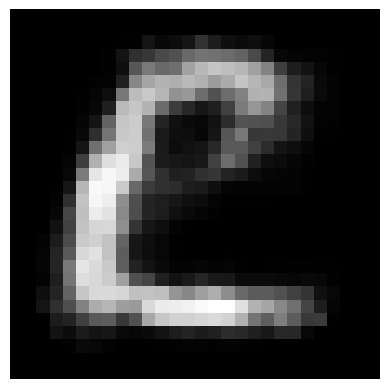

In [38]:
y = vae.decoder(z)
draw(y)

## Convolutional Approach

100%|██████████| 100/100 [01:19<00:00,  1.27it/s]


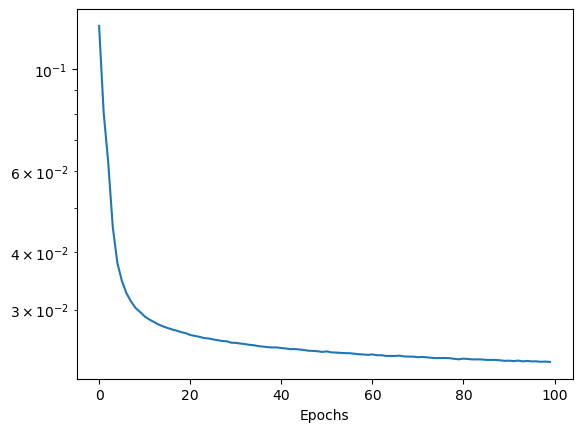

In [56]:
# Training the autoencoder
epochs = 100
lr = 0.001
latent_dim = 32
beta = 0.01

convae = ConvVAE(latent_dim=latent_dim, beta=beta, loss_fcn=nn.MSELoss())
convae.learn(dl, epochs=epochs, lr=lr)

# log_training_session({
#     'epochs': epochs,
#     'lr': lr,
#     'h_dim': h_dim,
#     'latent_dim': latent_dim,
#     'beta': beta,
#     'final_loss': vae.losses[-1]  # final loss after training
# })

### Reconstructing Images

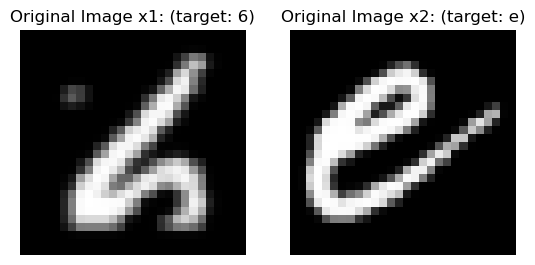

In [57]:
idx1 = random.randint(0, 3204)
x1, t1 = ds_conv.__getitem__(idx1)

idx2 = random.randint(0, 3204)
x2, t2 = ds_conv.__getitem__(idx2)

plt.subplot(1,2, 1)
draw(x1, f"Original Image x1: (target: {convert_i2c(t1)})")
plt.subplot(1,2, 2)

draw(x2, f"Original Image x2: (target: {convert_i2c(t2)})")

In [58]:
# Encode images into latent distributions
mu1, sigma1 = convae.encoder(x1.unsqueeze(0))
mu2, sigma2 = convae.encoder(x2.unsqueeze(0))

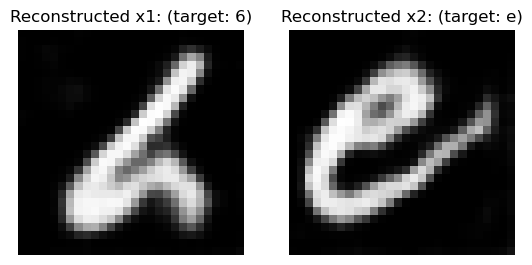

In [59]:
y1 = convae.decoder(mu1)
y1 = y1.squeeze(0)

plt.subplot(1,2,1)
draw(y1, f"Reconstructed x1: (target: {convert_i2c(t1)})")

y2 = convae.decoder(mu2)
y2 = y2.squeeze(0)
plt.subplot(1,2,2)
draw(y2, f"Reconstructed x2: (target: {convert_i2c(t2)})")

### Generative Sampling from Convolutional VAEs

In [87]:
z = torch.randn(convae.latent_dim)
z

tensor([ 5.5393e-01, -2.0538e+00,  1.8811e+00, -2.3013e-01, -1.3470e+00,
        -2.6237e-01,  1.9726e-01,  2.8311e-02, -3.5359e+00,  4.0648e-01,
         2.7474e-01,  2.0690e-03,  4.2882e-01, -2.8133e-02, -2.9829e-01,
        -1.1980e-01, -1.0556e-01, -1.1281e+00,  1.0501e+00, -1.2522e+00,
        -6.1214e-01, -3.7221e-01, -4.6415e-01,  3.3473e-01, -1.1963e+00,
        -4.2107e-01, -6.6034e-01, -6.7140e-01,  8.8830e-03, -1.8894e-01,
         4.5494e-01,  1.0625e+00])

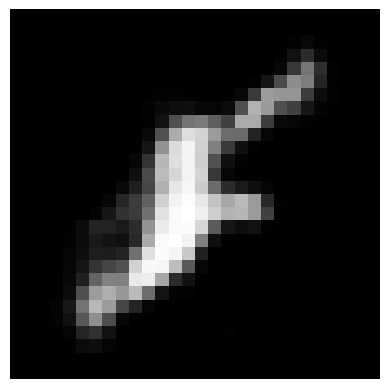

In [88]:
y = convae.decoder(z)
draw(y.squeeze(0))